In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

C:\Users\remil\.conda\envs\lcpfn\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import lcpfn 
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import torch
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
# curve data is 100 points
# split data into 50 and 50
# given first 50 points predict next 50 points
input_length = 15  # Num input elements
target_length = 85  # Num target elements

# get data (100 curves)
# Y seems to be the true curve data, X is just indecies???
get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)
X, Y, Y_noisy = get_batch_func(batch_size=100, seq_len=100, num_features=1)

# Splitting data into input and target
# input given to transformer who's output is compared to target
inputs = Y[:, :input_length]
targets = Y[:, input_length : input_length + target_length]

#load data
dataset = TensorDataset(inputs, targets)
data_loader = DataLoader(
    dataset, batch_size=10, shuffle=True
)  

# not already implemented by torch
# encodes positional data of order the tokens are in the sequence
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )
        self.encoder = nn.Linear(input_dim, model_dim)
        self.decoder = nn.Linear(model_dim, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.model_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # Assuming output shape is [batch_size, input_seq_len, model_dim], e.g., [10, 15, 512]
        # This next step is conceptually for demonstration and likely not suitable for actual sequence generation:
        output = torch.mean(output, dim=1)  # Reduce over the sequence dimension, resulting in [batch_size, model_dim]
        output = self.decoder(output).unsqueeze(1)  # Decoder now expects [batch_size, model_dim], unsqueeze for compatibility
        # Expand or repeat the output to match the target length, although this is not a genuine sequence generation
        output = output.repeat(1, target_length, 1)  # Naive repeat to match [batch_size, target_length, output_dim]
        return output.squeeze(-1)  # Adjust dimensions to match [batch_size, target_length]



model = TransformerModel(
    input_dim=1,
    model_dim=512,
    num_heads=8,
    num_layers=6,
    dim_feedforward=2048,
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0.0
    for input_sequence, target_sequence in data_loader:
        optimizer.zero_grad()
        # Reshaping input to match the model's input shape
        input_sequence = input_sequence.unsqueeze(-1)
        output = model(input_sequence)
        print(output.shape)
        # print(output.shape, target_sequence.shape)
        loss = criterion(output, target_sequence)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader)}")


torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])
Epoch 0, Loss: 52.23170831799507
torch.Size([10, 85])
torch.Size([10, 85])
torch.Size([10, 85])


## Load trained LC-PFN model

In [21]:
model = lcpfn.LCPFN()

## Generate a learning curve from the prior

In [22]:
print("test")

test


(0.0, 1.0)

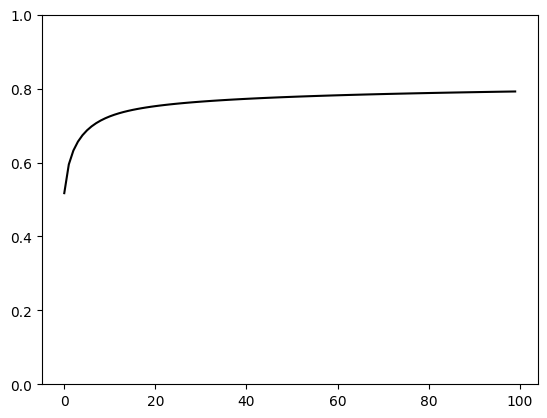

In [23]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black")
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10% 

In [24]:
# construct 

x = torch.arange(1, 101).unsqueeze(1)
y = torch.from_numpy(curve).float().unsqueeze(1)
cutoff = 10

In [25]:
predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

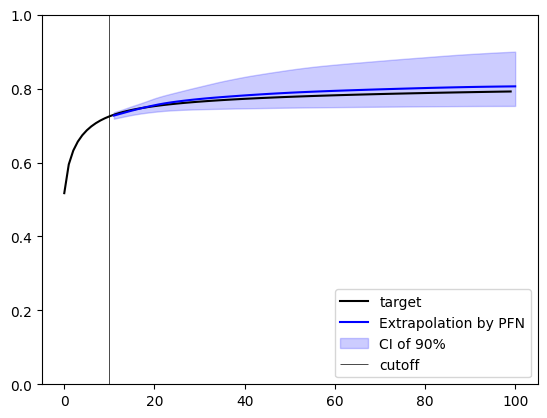

In [26]:
# plot data
plt.plot(curve, "black", label="target")

# plot extrapolation
plt.plot(x[cutoff:], predictions[:, 1], "blue", label="Extrapolation by PFN")
plt.fill_between(
        x[cutoff:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
)

# plot cutoff
plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
plt.ylim(0, 1)
plt.legend(loc="lower right")